# Data Preparation 

In [3]:
!kaggle datasets download -d suryadeepti/movie-lens-dataset


  0%|          | 0.00/846k [00:00<?, ?B/s]
100%|██████████| 846k/846k [00:00<00:00, 1.21MB/s]
100%|██████████| 846k/846k [00:00<00:00, 1.21MB/s]


In [3]:
import os
import zipfile
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

import tensorflow as tf
import keras
from keras.models import Model
from keras import layers
from tensorflow.keras.optimizers import Adam
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

In [6]:
zip_file = 'movie-lens-dataset.zip'
zip_file = zipfile.ZipFile(zip_file, 'r')
zip_file.extractall()
zip_file.close()

# Data Understanding

## Data Load

In [7]:
data_movie = pd.read_csv(r'Data\movies.csv')
data_ratings = pd.read_csv(r'Data\ratings.csv')

#### Data Movie

In [9]:
data_movie.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [8]:
data_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [10]:
np.sum(data_movie.isnull())

d:\Materi_data-science\Dicoding_Rekomendasi\env\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


movieId    0
title      0
genres     0
dtype: int64

### Data Rating

In [11]:
data_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [12]:
data_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [13]:
np.sum(data_ratings.isnull())

d:\Materi_data-science\Dicoding_Rekomendasi\env\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Knowledge: 
- Terdapat 3 fitur pada movie, dan 4 fitur pada ratings. Dilihat pada movieId adalah sebuah foreign key untuk data movie sehingga data bisa di merge
- Tidak terdapat sebuah `null value`,

## Data Preprocessing


Karena timestamp tidak digunakan untuk rekomendasi maka bisa di drop

In [ ]:
data_ratings = data_ratings.drop(['timestamp'], axis=1)

### Merge Data
- Merge data movie dan data ratings berdasarkan fitur movieId

In [27]:
data = data_ratings.merge(data_movie, how='inner', on='movieId')
data.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


### Normalize the fitur rating

In [28]:
batas_bawah = min(data['rating'])
batas_atas = max(data['rating'])
data['rating'] = data['rating'].apply(lambda x : (x - batas_bawah) / (batas_atas - batas_bawah)).values.astype(np.float32)
avg_rating = np.mean(data['rating'])

In [29]:
print('Rata Rata Rating oleh setiap user:', avg_rating)

Rata Rata Rating oleh setiap user: 0.6670127


In [30]:
userId = data['userId'].unique().tolist()
encoderUser = { x : i for i, x in enumerate(userId)}

encodertoUser = { i : x for i, x in enumerate(userId)}

data['user'] = data['userId'].map(encoderUser)
n_user = len(encoderUser)

movieId = data['movieId'].unique().tolist()

encoderMovie = { x: i for i, x in enumerate(movieId)}
encodertoMovie = { i : x for i, x in enumerate(movieId)}

data['movie'] = data['movieId'].map(encoderMovie)
n_movie = len(encoderMovie)

In [34]:
data

,userId,movieId,rating,title,genres,user,movie
0,1,1,0.777778,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0
1,1,3,0.777778,Grumpier Old Men (1995),Comedy|Romance,0,1
2,1,6,0.777778,Heat (1995),Action|Crime|Thriller,0,2
3,1,47,1.000000,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0,3
4,1,50,1.000000,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0,4
...,...,...,...,...,...,...,...
100831,610,166534,0.777778,Split (2017),Drama|Horror|Thriller,609,3120
100832,610,168248,1.000000,John Wick: Chapter Two (2017),Action|Crime|Thriller,609,2035
100833,610,168250,1.000000,Get Out (2017),Horror,609,3121
100834,610,168252,1.000000,Logan (2017),Action|Sci-Fi,609,1392


In [35]:
print('Jumlah User: {}'.format(n_user))
print('Jumlah Movie: {}'.format(n_movie))

print('Batas Bawah: {}'.format(min(data['rating'])))
print('Batas Atas: {}'.format(max(data['rating'])))

Jumlah User: 610
Jumlah Movie: 9724
Batas Bawah: 0.0
Batas Atas: 1.0


In [38]:
X = data[['user', 'movie']].values
y = data['rating']

# membagi data
test_size = int(2e5)
indices = data.shape[0] - test_size
X_train, X_test, y_train, y_test = (X[:indices], X[indices:], y[:indices], y[indices:])

X_train = [X_train[:, 0], X_train[:, 1]]
X_test = [X_test[:, 0], X_test[:, 1]]


In [42]:
def model_architecture():
    user = Input(name='user', shape=[1])
    user_embed = Embedding(name='user_embedding', input_dim= n_user, output_dim=128)(user)
    
    movie = Input(name='movie', shape=[1])
    movie_embed = Embedding(name = 'movie_embedding', input_dim=n_movie, output_dim=128)(movie)
    
    X = Dot(name = 'dot_product', normalize=True, axes=2)([user_embed, movie_embed])
    X = Flatten()(X)
    X = Dense(1, kernel_initializer='he_normal')(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = [user, movie], outputs = X)
    model.compile(loss= 'binary_crossentropy',
                  metrics = ['mse', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
                  optimizer = 'Adam')
    return model

In [43]:
model = model_architecture()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │     78,080 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 128)    │  1,244,672 │ movie[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ dense[0][0]       │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,322,754 (5.05 MB)

 Trainable params: 1,322,754 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Correcting the filepath to match the expected format
model_checkpoint = ModelCheckpoint(filepath='./weight.weights.h5',
                             save_weights_only=True,
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True)

early_stopping = EarlyStopping(patience=1, 
                               monitor='mse', 
                               mode='min', 
                               restore_best_weights=True)

my_callbacks = [model_checkpoint, early_stopping]


In [48]:
history = model.fit(x = X_train,
                    y = y_train,
                    validation_data = (X_test, y_test),
                    epochs = 30,
                    batch_size = 32,
                    verbose = 1,
                    callbacks = my_callbacks)

Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.6913 - mse: 0.0988 - precision: 0.9745 - recall: 0.6018 - val_loss: 0.6853 - val_mse: 0.0773 - val_precision: 0.9865 - val_recall: 0.8885
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.6603 - mse: 0.0865 - precision: 0.9954 - recall: 0.9234 - val_loss: 0.6784 - val_mse: 0.0739 - val_precision: 0.9865 - val_recall: 0.9790
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.6312 - mse: 0.0685 - precision: 0.9980 - recall: 0.8925 - val_loss: 0.6727 - val_mse: 0.0710 - val_precision: 0.9865 - val_recall: 0.9942
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.6014 - mse: 0.0559 - precision: 0.9999 - recall: 0.8943 - val_loss: 0.6680 - val_mse: 0.0687 - val_precision: 0.9865 - val_recall: 0.9980
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.5777 - mse: 0.0451 - precision: 1.0000 - recall: 0.8856 - val_loss: 0.6642 - val_mse: 0.0668 - val_precision: 0.9865 - val_recall: 0.9989
Epoch

# Evaluasi Performance

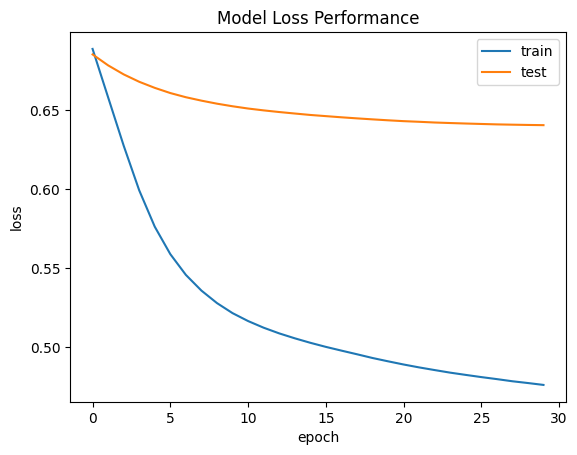

In [52]:
plt.title('Model Loss Performance')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

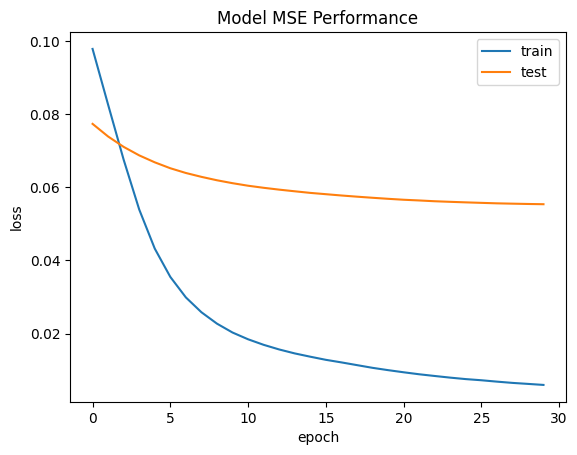

In [53]:
plt.title('Model MSE Performance')
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

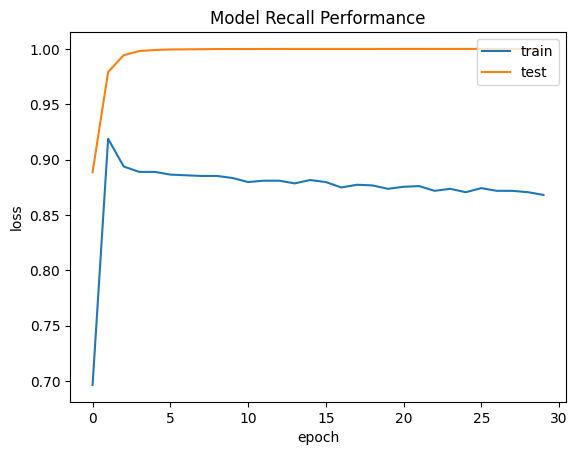

In [54]:
plt.title('Model Recall Performance')
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

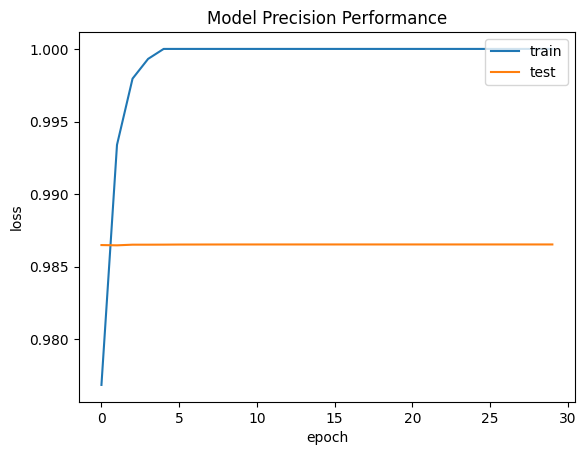

In [55]:
plt.title('Model Precision Performance')
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [56]:
def weight_model(name, model):
    weight = model.get_layer(name).get_weights()[0]
    weight = weight / np.linalg.norm(weight, axis = 1).reshape((-1, 1))
    return weight

movie_weight = weight_model('movie_embedding', model)
user_weight = weight_model('user_embedding', model)

In [57]:
def get_similar_users(tempId, n = 10):
      index = tempId
      weights = user_weight
      dists = np.dot(weights, weights[encoderUser.get(index)])
      sortedDists = np.argsort(dists)
      n += 1
      closest = sortedDists[-n:]
      print('User that similar to user #{}'.format(tempId))
      
      SimilarArr = []
      
      for close in closest:
          similarity = dists[closest]

          if isinstance(tempId, int):
              SimilarArr.append({"similar_users" : encodertoUser.get(close), "similarity" : similarity})

      Frame = pd.DataFrame(SimilarArr)
      return Frame

In [89]:
get_similar_users(393)['similar_users']

User that similar to user #393


0     465
1       6
2     147
3     214
4     418
5      18
6      10
7     488
8     469
9     210
10    393
Name: similar_users, dtype: int64

In [90]:
def movie_preference(userId, plot = False, temp = 1):
  
  # menentukan batas rating terendah movie
  low_rating = np.percentile(data[data['userId'] == userId]['rating'], 75)
  data[data['userId'] == userId] = data[data['userId'] == userId][data[data['userId'] == userId]['rating'] >= low_rating]
  top_movie_refference = (data[data['userId'] == userId].sort_values(by = "rating", ascending = False)['movieId'].values)
  
  user_pref_df = data[data["movieId"].isin(top_movie_refference)]
  user_pref_df = user_pref_df[["movieId","title", "genres"]]
  
  if temp != 0:
      print("Berikut ini adalah list rekomendasi film dari user dengan id #{} yang telah mereview {} film dengan rata-rata ratingnya adalah = {:.1f}/5.0".format(
        userId, len(data[data['userId']==userId]),
        data[data['userId']==userId]['rating'].mean()*5,
      ))

  return user_pref_df
     

In [91]:
reff_user = movie_preference(393, plot = True)
reff_user = pd.DataFrame(reff_user)
reff_user.head(10)

Berikut ini adalah list rekomendasi film dari user dengan id #393 yang telah mereview 68 film dengan rata-rata ratingnya adalah = 5.0/5.0


,movieId,title,genres
25,457.0,"Fugitive, The (1993)",Thriller
62,1089.0,Reservoir Dogs (1992),Crime|Mystery|Thriller
70,1198.0,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
71,1206.0,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller
89,1291.0,Indiana Jones and the Last Crusade (1989),Action|Adventure
147,2329.0,American History X (1998),Crime|Drama
166,2571.0,"Matrix, The (1999)",Action|Sci-Fi|Thriller
192,2959.0,Fight Club (1999),Action|Crime|Drama|Thriller
197,2997.0,Being John Malkovich (1999),Comedy|Drama|Fantasy
228,3793.0,X-Men (2000),Action|Adventure|Sci-Fi
